In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import pickleslicer
from stoqcompiler.unitary import *
from stoqcompiler.verification import *

import jaqalpaq
from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit
from jaqalpaq.generator import generate_jaqal_program
from qscout.v1.native_gates import U_R, U_MS, U_Rz

## Define the 5-qubit system parameters

In [2]:
num_system_qubits = 5

qubit_dimension = 2
system_dimension = qubit_dimension ** num_system_qubits
qubits_to_use = [q for q in range(num_system_qubits)]

def qscout_r(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "R"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_R, parameters, operation_name), allowed_apply_to)

def qscout_rz(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "Rz"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_Rz, parameters, operation_name), allowed_apply_to)

def qscout_ms(max_angle):
    min_value = -max_angle
    max_value = max_angle
    dimension = 2
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "MS"
    connectivity = [[i,j] for i in range(num_system_qubits) for j in range(num_system_qubits) if i != j]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension ** 2, U_MS, parameters, operation_name), allowed_apply_to)

## How RAV uncertainty scales with # of shots

- Choose a representative long-enough random RAV circuit with ideal output state $\lvert\psi\rangle \approx \sqrt{1-\epsilon} \lvert0\rangle + \sqrt{\epsilon} \lvert\textrm{other states}\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\psi\rangle\langle\psi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [3]:
unitary_primitive_counts = {
    qscout_r(max_angle=np.pi/10): 3,
    qscout_rz(max_angle=np.pi/10): 3,
    qscout_ms(max_angle=np.pi/10): 1
}

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
directory = f"output_ideal_rav_vs_xeb_simulations/{timestamp}"
if not os.path.exists(directory):
    os.makedirs(directory)

In [4]:
sequence_count = 5
layer_count = 10

rav_results = []
for seq_idx in range(sequence_count):
    final_cost = 1.0
    while final_cost > 0.05:
        rav_result = Verification.generate_layered_rav_sequence(
            system_dimension,
            unitary_primitive_counts,
            layer_count,
            max_step_count = 20000,
            threshold = 1.0,
        )

        product = rav_result.compiled_sequence.product()
        identity = Unitary.identity(system_dimension)
        final_cost = product.distance_from(identity)

        print(f"generated circuit: length {rav_result.compiled_sequence.get_length()} with final cost {final_cost}")

    rav_results.append(rav_result)
    filename = f'{directory}/rav_{num_system_qubits}q_{layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(rav_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated circuit: length 189 with final cost 0.03933593368484323
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/rav_5q_10_0.txt
generated circuit: length 147 with final cost 0.026327633864710154
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/rav_5q_10_1.txt
generated circuit: length 175 with final cost 0.0295177025349449
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/rav_5q_10_2.txt
generated circuit: length 161 with final cost 0.04789742507855843
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/rav_5q_10_3.txt
generated circuit: length 126 with final cost 0.028700724542940925
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/rav_5q_10_4.txt


In [5]:
rav_x_data = {}
rav_y_data = {}    
for seq_idx, rav_result in enumerate(rav_results):
    rav_sequence_matrix = rav_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    rav_x_data[seq_idx] = {}
    rav_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = rav_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        rav_x_data[seq_idx][mixed_state_fraction] = []
        rav_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                scaled_fidelity = (np.mean(measurements) - 1/system_dimension) * (system_dimension/(system_dimension-1))

                rav_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                rav_y_data[seq_idx][mixed_state_fraction].append(scaled_fidelity)

mixed_state_fraction = 0.0, output_probs = [2.000e-04 9.282e-01 0.000e+00 1.100e-03 0.000e+00 1.100e-03 0.000e+00
 9.300e-03 1.700e-03 6.800e-03 0.000e+00 1.040e-02 0.000e+00 8.500e-03
 1.000e-04 2.000e-04 1.900e-03 3.800e-03 1.000e-04 3.200e-03 1.000e-04
 1.260e-02 3.000e-04 3.000e-04 1.000e-04 9.700e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e-04]
mixed_state_fraction = 0.25, output_probs = [0.0079 0.704  0.0078 0.0086 0.0078 0.0086 0.0078 0.0148 0.0091 0.0129
 0.0078 0.0156 0.0078 0.0142 0.0079 0.008  0.0092 0.0106 0.0079 0.0102
 0.0079 0.0173 0.008  0.008  0.0079 0.0151 0.0078 0.0078 0.0078 0.0078
 0.0078 0.0079]
mixed_state_fraction = 0.5, output_probs = [0.0157 0.4797 0.0156 0.0162 0.0156 0.0162 0.0156 0.0203 0.0165 0.019
 0.0156 0.0208 0.0156 0.0199 0.0157 0.0157 0.0166 0.0175 0.0157 0.0172
 0.0157 0.0219 0.0158 0.0158 0.0157 0.0205 0.0156 0.0156 0.0156 0.0156
 0.0156 0.0157]
mixed_state_fraction = 0.75, output_probs = [0.0235 0.2555 0.0234 0.0237 0.0234 0.0237 

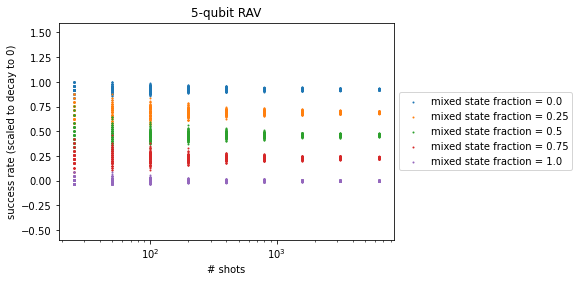

In [6]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        rav_x_data[0][mixed_state_fraction],
        rav_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')
    
plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('success rate (scaled to decay to 0)')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
rav_std_data = {}
for seq_idx, rav_result in enumerate(rav_results):
    rav_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        rav_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(rav_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, rav_y_data[seq_idx][mixed_state_fraction])
            rav_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

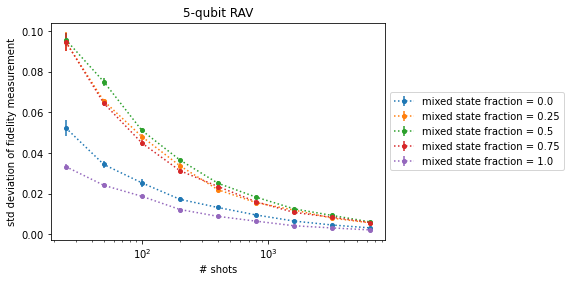

In [8]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [rav_std_data[seq_idx][mixed_state_fraction] for seq_idx in rav_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## How XEB uncertainty scales with # of shots

- Choose a representative random circuit of same length used above for RAV with ideal output state $\lvert\phi\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\phi\rangle\langle\phi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [9]:
xeb_results = []
for seq_idx in range(sequence_count):
    xeb_layer_count = rav_results[seq_idx].compiled_sequence.get_length() // int(sum(list(unitary_primitive_counts.values())))

    xeb_result = Verification.generate_layered_rav_sequence(
        system_dimension,
        unitary_primitive_counts,
        xeb_layer_count,
        max_step_count = 0,
        threshold = 0.0,
    )

    product = xeb_result.compiled_sequence.product()
    identity = Unitary.identity(system_dimension)
    final_cost = product.distance_from(identity)

    print(f"generated XEB circuit: length {xeb_result.compiled_sequence.get_length()} with final cost {final_cost}")

    xeb_results.append(xeb_result)

    filename = f'{directory}/xeb_{num_system_qubits}q_{xeb_layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(xeb_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated XEB circuit: length 189 with final cost 0.6677823330555139
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/xeb_5q_27_0.txt
generated XEB circuit: length 147 with final cost 0.4303920956541477
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/xeb_5q_21_1.txt
generated XEB circuit: length 175 with final cost 0.5306848671243718
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/xeb_5q_25_2.txt
generated XEB circuit: length 161 with final cost 0.6158952997450181
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/xeb_5q_23_3.txt
generated XEB circuit: length 126 with final cost 0.47535345822855435
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_120127/xeb_5q_18_4.txt


In [10]:
xeb_x_data = {}
xeb_y_data = {}    
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_sequence_matrix = xeb_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    xeb_x_data[seq_idx] = {}
    xeb_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = xeb_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        xeb_x_data[seq_idx][mixed_state_fraction] = []
        xeb_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                measurements = np.random.choice(system_dimension, size=n_shots, p=output_probs)
                measurement_probs = [np.count_nonzero(measurements == k) / n_shots for k in range(system_dimension)]
                assert np.isclose(np.sum(measurement_probs), 1.0)

                # calculate cross-entropy fidelity between ideal_output_probs, measurement_probs
                e_u = np.sum(ideal_output_probs**2)
                u_u = np.sum(ideal_output_probs) / system_dimension
                m_u = np.sum(ideal_output_probs * measurement_probs)
                y = m_u - u_u
                x = e_u - u_u
                fidelity = (x * y) / (x ** 2)

                xeb_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                xeb_y_data[seq_idx][mixed_state_fraction].append(fidelity)

mixed_state_fraction = 0.0, output_probs = [3.050e-02 3.925e-01 6.200e-03 1.700e-03 1.430e-02 9.160e-02 1.700e-03
 3.400e-03 2.060e-02 4.320e-02 3.000e-04 2.800e-03 6.800e-03 3.100e-03
 1.100e-03 0.000e+00 6.700e-03 1.684e-01 2.900e-03 5.580e-02 3.600e-03
 3.000e-02 2.300e-03 1.410e-02 1.770e-02 6.540e-02 4.000e-04 2.500e-03
 4.800e-03 5.400e-03 2.000e-04 0.000e+00]
mixed_state_fraction = 0.25, output_probs = [0.0307 0.3022 0.0124 0.0091 0.0186 0.0765 0.0091 0.0104 0.0233 0.0402
 0.008  0.0099 0.0129 0.0101 0.0086 0.0078 0.0128 0.1341 0.01   0.0497
 0.0105 0.0303 0.0096 0.0184 0.0211 0.0569 0.0081 0.0097 0.0114 0.0119
 0.008  0.0078]
mixed_state_fraction = 0.5, output_probs = [0.0309 0.2119 0.0187 0.0165 0.0228 0.0614 0.0165 0.0173 0.0259 0.0372
 0.0158 0.017  0.019  0.0172 0.0162 0.0156 0.019  0.0998 0.0171 0.0435
 0.0174 0.0306 0.0168 0.0227 0.0245 0.0483 0.0158 0.0169 0.018  0.0183
 0.0157 0.0156]
mixed_state_fraction = 0.75, output_probs = [0.0311 0.1216 0.025  0.0239 0.027  0.0463

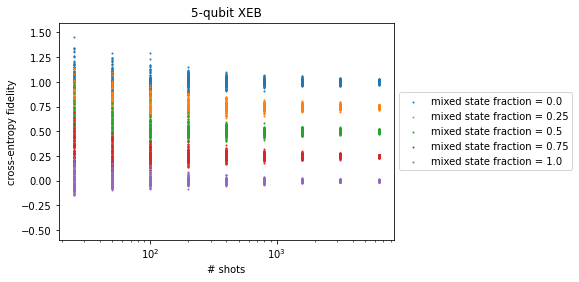

In [11]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        xeb_x_data[0][mixed_state_fraction],
        xeb_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')

plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('cross-entropy fidelity')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
xeb_std_data = {}
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        xeb_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(xeb_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, xeb_y_data[seq_idx][mixed_state_fraction])
            xeb_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

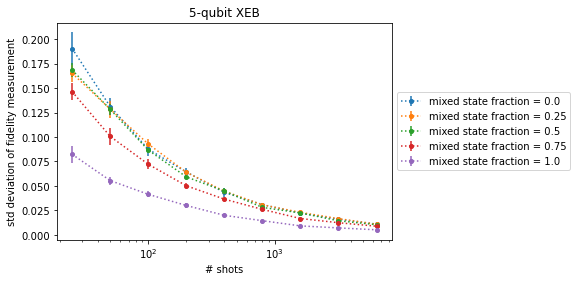

In [13]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [xeb_std_data[seq_idx][mixed_state_fraction] for seq_idx in xeb_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
save_data = {
    "mixed_state_fraction_list": mixed_state_fraction_list,
    "n_shots_list": n_shots_list,
    "rav_x_data": rav_x_data,
    "rav_y_data": rav_y_data,
    "rav_std_data": rav_std_data,
    "xeb_x_data": xeb_x_data,
    "xeb_y_data": xeb_y_data,
    "xeb_std_data": xeb_std_data,
}
pickleslicer.dump(save_data, f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
print(f'Saved to {directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')

Saved to output_ideal_rav_vs_xeb_simulations/20220417_120127/ideal_rav_vs_xeb_simulations_5q.pickle


In [3]:
directory = 'output_ideal_rav_vs_xeb_simulations/20220417_120127'
load_data = pickleslicer.load(f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
mixed_state_fraction_list = load_data["mixed_state_fraction_list"]
n_shots_list = load_data["n_shots_list"]
rav_x_data = load_data["rav_x_data"]
rav_y_data = load_data["rav_y_data"]
rav_std_data = load_data["rav_std_data"]
xeb_x_data = load_data["xeb_x_data"]
xeb_y_data = load_data["xeb_y_data"]
xeb_std_data = load_data["xeb_std_data"]